## 基于GP的集成学习
集成学习是一种机器学习方法，它通过结合多个学习器来解决单个学习器难以解决的问题。通过集成学习，可以提高预测精度，降低过拟合风险。
集成学习的代表性方法包括随机森林、Adaboost、XGBoost等。这些方法都是基于决策树的集成学习方法。在本教程中，我们将介绍如何使用遗传编程（GP）来进行集成学习。
GP是一种基于种群的优化算法，非常适合用于集成学习。

### 评估函数
对于集成学习，多样性非常重要。因此，在评估个体时，建议使用随机决策树或其他随机性较高的算法。这样可以产生多样性的GP个体。
随机决策树是指在决策树算法中，随机选择特征进行分裂。在sklearn中，可以通过设置splitter="random"来实现。

In [31]:
from sklearn.datasets import load_iris

# 假设我们有一个分类问题，输入为X，输出为y
X,y=load_iris(return_X_y=True)

# 目标是最大化分类精度
def evalFeatureEngineering(trees):
    # 创建新特征
    new_features = []
    for tree_id, tree in enumerate(trees):
        func = gp.compile(expr=tree, pset=pset)
        new_features.append([func(*record) for record in X])
    
    # 转置新特征数组
    new_features = np.transpose(np.array(new_features))
    
    # 使用决策树分类器
    clf = DecisionTreeClassifier(splitter="random")
    clf.fit(new_features, y)
    
    # 使用交叉验证计算误差
    scores = cross_val_score(clf, new_features, y, cv=5)
    
    # 返回平均分类精度
    return scores.mean(),

### 多树GP
集成学习中可以选择使用单树GP或多树GP，两者都是可行的。在本教程中，我们使用多树GP来表示个体。
每个GP树可以视为一个特征，因此，每个个体可以视为一个特征集合。

In [32]:
import operator
import random
import numpy as np
from deap import base, creator, tools, gp, algorithms
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# 创建GP框架的基本组件
pset = gp.PrimitiveSet("MAIN", X.shape[1])
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.neg, 1)
pset.addEphemeralConstant("rand101", lambda: random.random() * 2 - 1)

# 创建一个适应度类和个体类，个体由多棵树组成
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

C:\Users\zhenl\anaconda3\Lib\site-packages\deap\gp.py:254: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "
C:\Users\zhenl\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\zhenl\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


### 交叉/变异算子
交叉和变异算子无需额外修改。

In [33]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)

# 初始化每个个体为一个包含多棵树的列表
def initIndividual(container, func, size):
    return container(gp.PrimitiveTree(func()) for _ in range(size))

# 交叉和变异算子需要能够处理个体的列表结构
def cxOnePointListOfTrees(ind1, ind2):
    for tree1, tree2 in zip(ind1, ind2):
        gp.cxOnePoint(tree1, tree2)
    return ind1, ind2

def mutUniformListOfTrees(individual, expr, pset):
    for tree in individual:
        gp.mutUniform(tree, expr=expr, pset=pset)
    return individual,

toolbox.register("individual", initIndividual, creator.Individual, toolbox.expr, size=3)  # 假设我们创建3个特征
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evalFeatureEngineering)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", cxOnePointListOfTrees)
toolbox.register("mutate", mutUniformListOfTrees, expr=toolbox.expr, pset=pset)
toolbox.register("compile", gp.compile, pset=pset)

### 存档机制
对于集成学习，我们需要保存最佳的个体集合，而不仅仅是最佳个体。因此，我们需要将HallOfFame的存档数量从1提高到20。

In [34]:
# 运行遗传编程算法
population = toolbox.population(n=50)
hof = tools.HallOfFame(20)

# 统计和日志
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop, log = algorithms.eaSimple(population, toolbox, 0.9, 0.1, 10, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg     	std      	min     	max 
0  	50    	0.901733	0.0723917	0.653333	0.96
1  	46    	0.9236  	0.0476508	0.693333	0.973333
2  	47    	0.928667	0.0421479	0.713333	0.973333
3  	50    	0.9116  	0.096026 	0.333333	0.98    
4  	47    	0.9244  	0.0724506	0.493333	0.973333
5  	45    	0.943067	0.0434145	0.66    	0.973333
6  	46    	0.942   	0.0383493	0.706667	0.966667
7  	44    	0.9512  	0.0142011	0.906667	0.98    
8  	43    	0.952667	0.0162891	0.88    	0.973333
9  	50    	0.9476  	0.019777 	0.866667	0.973333
10 	48    	0.948133	0.0215938	0.833333	0.973333


### 集成预测
最后，根据最佳个体集合，可以使用投票法进行集成预测。

In [35]:
# 使用保存的最佳个体集合进行集成预测
def ensemblePredict(hof, X):
    # 对每个个体，使用它创建的特征进行预测
    predictions = []
    for ind in hof:
        print('Individual:', [str(tree) for tree in ind])
        # 创建新特征
        new_features = []
        for tree_id, tree in enumerate(ind):
            func = gp.compile(expr=tree, pset=pset)
            new_features.append([func(*record) for record in X])
        
        # 转置新特征数组
        new_features = np.transpose(np.array(new_features))
        
        # 在这里我们只是简单的使用了新特征，并没有使用原始特征
        # 在实际应用中可能需要结合新老特征
        clf = DecisionTreeClassifier(splitter='random')
        clf.fit(new_features, y)
        predictions.append(clf.predict(new_features))

    # 对预测结果进行集成
    # 这里我们使用简单多数投票，可以根据需要使用其他集成方法
    ensemble_pred = np.apply_along_axis(lambda x: np.bincount(x, minlength=3).argmax(), axis=0, arr=np.array(predictions))
    return ensemble_pred

# 测试集成预测函数
ensemble_pred = ensemblePredict(hof, X)
print('Ensemble prediction:', ensemble_pred[:5])

Individual: ['mul(mul(ARG3, 0.7358396140530001), ARG2)', 'mul(add(ARG3, ARG3), ARG2)', 'add(sub(sub(ARG2, 0.6869738372629233), ARG0), 0.5735715361787475)']
Individual: ['add(mul(ARG3, ARG2), ARG1)', 'mul(sub(0.8342690417922825, ARG2), ARG3)', 'neg(0.5735715361787475)']
Individual: ['add(mul(ARG3, ARG2), ARG3)', 'mul(ARG3, ARG3)', 'neg(ARG2)']
Individual: ['mul(ARG2, ARG3)', 'mul(add(ARG3, ARG3), sub(0.8342690417922825, ARG3))', 'add(ARG2, ARG2)']
Individual: ['mul(0.06235947083395965, add(ARG3, ARG3))', 'add(neg(ARG2), ARG3)', 'mul(add(ARG2, ARG0), neg(ARG2))']
Individual: ['mul(ARG2, ARG3)', 'add(add(0.7923105656707392, ARG3), ARG3)', 'mul(ARG2, ARG2)']
Individual: ['mul(ARG2, ARG3)', 'add(ARG3, ARG3)', 'mul(ARG2, mul(ARG3, ARG2))']
Individual: ['mul(ARG3, ARG3)', 'add(ARG3, ARG3)', 'mul(0.6869738372629233, mul(ARG2, ARG2))']
Individual: ['mul(ARG3, ARG2)', 'mul(add(ARG3, ARG3), ARG2)', 'add(sub(sub(ARG2, 0.6869738372629233), ARG0), 0.5735715361787475)']
Individual: ['mul(ARG2, ARG3)'

此外，还可以统计特征的使用频率，从而得到特征重要性图。

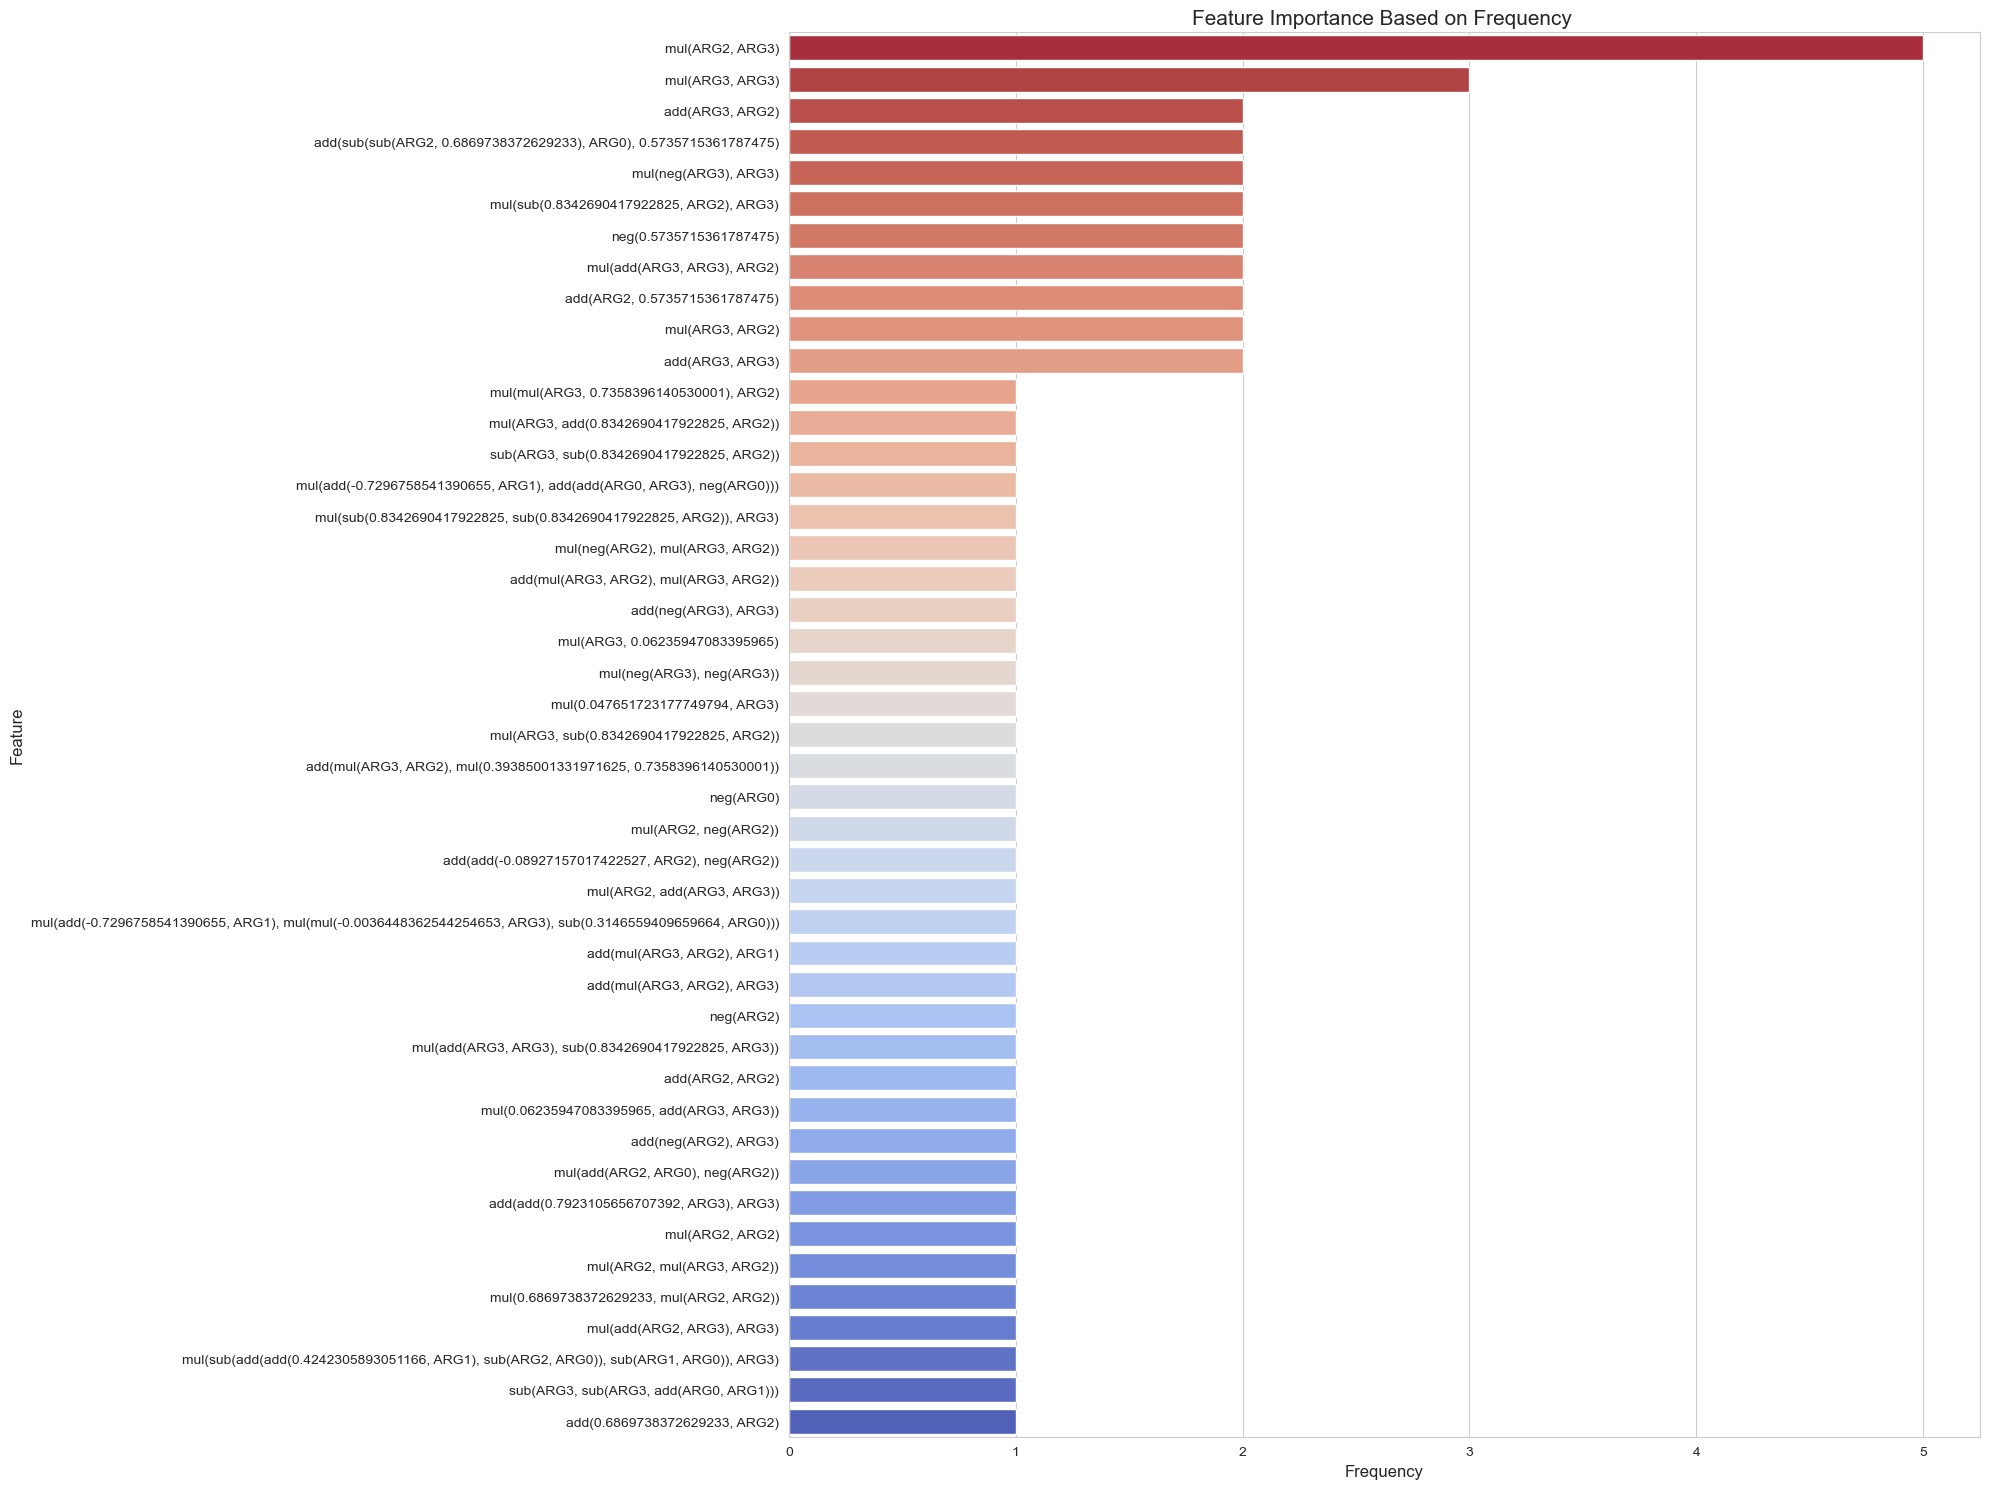

In [36]:

from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


feature_frequency = defaultdict(int)

for individual in hof:
    for tree in individual:
        feature_frequency[str(tree)]+=1

features_df = pd.DataFrame(list(feature_frequency.items()), columns=["Feature", "Frequency"])

# 对特征按照频率进行排序
features_df.sort_values("Frequency", ascending=False, inplace=True)

# 绘制特征重要性图
plt.figure(figsize=(20, 15))
palette = sns.color_palette("coolwarm", len(features_df))[::-1]
sns.barplot(x="Frequency", y="Feature", data=features_df, palette=palette)
plt.title("Feature Importance Based on Frequency ", fontsize=15)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout() 
plt.show()